In [1]:
import keras 
from keras.datasets import mnist
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from keras.layers import Dense, Flatten
from keras import optimizers
from keras.models import Sequential
from keras.layers import Input, Lambda, Dense, Flatten, BatchNormalization, Activation
from keras.models import Model
from tensorflow.keras.applications import MobileNet
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
import numpy as np
from glob import glob
import matplotlib.pyplot as plt

In [2]:
# Training
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TensorBoard, CSVLogger
from keras.optimizers import SGD
from keras import backend as K

In [3]:
# Training
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TensorBoard, CSVLogger
from keras.optimizers import SGD
from keras import backend as K

In [4]:
from google.colab import drive

# Accessing My Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
trainset_dir = r"/content/drive/MyDrive/Dataset/Dataset_Shuffled/Train"
valset_dir = r"/content/drive/MyDrive/Dataset/Dataset_Shuffled/Validation"

In [ ]:
num_classes = 7
learning_rate = 1e-3
batch_size = 8
input_shape = (224, 224, 3)
momentum = 0.9

In [ ]:
train_datagen = ImageDataGenerator(rescale=1. / 255,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   fill_mode='nearest')

val_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = train_datagen.flow_from_directory(
    trainset_dir,
    target_size=(input_shape[0], input_shape[1]),
    batch_size=batch_size)

val_generator = val_datagen.flow_from_directory(
    valset_dir,
    target_size=(input_shape[0], input_shape[1]),
    batch_size=batch_size,
    shuffle=False)

Found 2677 images belonging to 7 classes.
Found 533 images belonging to 7 classes.


In [ ]:
K.clear_session()

In [ ]:
def precision(y_true, y_pred):
    '''Calculates the precision, a metric for multi-label classification of
    how many selected items are relevant.
    '''
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def recall(y_true, y_pred):
    '''Calculates the recall, a metric for multi-label classification of
    how many relevant items are selected.
    '''
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def accuracy(y_true, y_pred):
    '''Calculates the mean accuracy rate across all predictions for binary
    classification problems.
    '''
    return K.mean(K.equal(y_true, K.round(y_pred)))

In [ ]:
optim = SGD(lr=learning_rate, momentum=momentum)

In [ ]:
mobile = MobileNet(input_shape=input_shape, weights='imagenet', include_top=False)
#here [3] denotes for RGB images(3 channels)

#don't train existing weights
for layer in mobile.layers:
 layer.trainable = False

x = AveragePooling2D()(mobile.output)
x2 = Flatten()(x)
prediction = Dense(7, activation='softmax')(x2)

17227776/17225924 [==============================] - 0s 0us/step


In [ ]:
model = Model(inputs=mobile.input, outputs=prediction)
model.compile(loss='categorical_crossentropy',
                    optimizer=optim,
                    metrics=[precision,recall,'accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128       
_________________________________________________________________
conv_dw_1_relu (ReLU)        (None, 112, 112, 32)      0     

In [ ]:
csv_path = r"/content/drive/MyDrive/MobileNet/result_show/mobilenet.csv"
log_dir = r"/content/drive/MyDrive/MobileNet/result_show/mobilenet"
save_weights_path = r"/content/drive/MyDrive/MobileNet/weights/trash-model-weight-ep-{epoch:02d}-val_loss-{val_loss:.4f}-val_acc-{val_accuracy:.4f}.h5"

In [ ]:
checkpoint = ModelCheckpoint(save_weights_path, monitor='val_accuracy', verbose=1, 
                             save_weights_only=True, save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=20, verbose=1, min_lr=1e-4)

In [ ]:
earlystop = EarlyStopping(monitor='val_accuracy', patience=25, verbose=1)

In [ ]:
logging = TensorBoard(log_dir=log_dir)
csvlogger = CSVLogger(csv_path, append=True)
callbacks = [checkpoint, reduce_lr, logging, csvlogger]

In [ ]:
num_epochs = 500

In [ ]:
model.fit(train_generator,
          steps_per_epoch=len(train_generator),
          epochs=num_epochs,
          verbose=1, 
          callbacks=callbacks, 
          validation_data=val_generator, 
          validation_steps=len(val_generator),
          workers = 1)

Epoch 1/500
335/335 [==============================] - 695s 2s/step - loss: 3.1036 - precision: 0.5622 - recall: 0.5420 - accuracy: 0.5579 - val_loss: 2.6530 - val_precision: 0.7451 - val_recall: 0.7451 - val_accuracy: 0.7448

Epoch 00001: val_accuracy improved from -inf to 0.74484, saving model to /content/drive/MyDrive/MobileNet/weights/trash-model-weight-ep-01-val_loss-2.6530-val_acc-0.7448.h5
Epoch 2/500
335/335 [==============================] - 42s 126ms/step - loss: 2.5014 - precision: 0.7445 - recall: 0.7418 - accuracy: 0.7428 - val_loss: 2.0764 - val_precision: 0.7969 - val_recall: 0.7929 - val_accuracy: 0.7917

Epoch 00002: val_accuracy improved from 0.74484 to 0.79174, saving model to /content/drive/MyDrive/MobileNet/weights/trash-model-weight-ep-02-val_loss-2.0764-val_acc-0.7917.h5
Epoch 3/500
335/335 [==============================] - 42s 125ms/step - loss: 1.7916 - precision: 0.7984 - recall: 0.7963 - accuracy: 0.7975 - val_loss: 2.0001 - val_precision: 0.7854 - val_recal

In [5]:
#Testing
import numpy as np 
import tensorflow as tf 
import seaborn as sn
from matplotlib import pyplot as plt 
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import classification_report
from keras.preprocessing.image import ImageDataGenerator

In [7]:
import os

path = r"/content/drive/MyDrive/MobileNet/weights"
input_shape = (224, 224, 3)
num_classes = 7
testset_dir = r"/content/drive/MyDrive/Dataset/Dataset_Shuffled/Testing"
test_datagen = ImageDataGenerator(rescale=1. / 255)
test_generator = test_datagen.flow_from_directory(
    testset_dir,
    target_size=(input_shape[0], input_shape[1]),
    batch_size=140 , # The number of test images
    class_mode='categorical')
x_test, y_test = test_generator.__getitem__(0)
for file in os.listdir(path):
    filepath = os.path.join(path,file)
    
    mobile = MobileNet(input_shape=input_shape, weights='imagenet', include_top=False)
    x = AveragePooling2D()(mobile.output)
    x2 = Flatten()(x)
    prediction = Dense(7, activation='softmax')(x2)
    model = Model(inputs=mobile.input, outputs=prediction)
    model.load_weights(filepath)
    # Prediction on test set
    
    y_pred = model.predict(x_test)
    acc = np.count_nonzero(np.equal(np.argmax(y_pred, axis=1), np.argmax(y_test, axis=1)))/x_test.shape[0]
    print(filepath)
    print(acc)# Test set accuracy

Found 140 images belonging to 7 classes.
17227776/17225924 [==============================] - 0s 0us/step
/content/drive/MyDrive/MobileNet/weights/trash-model-weight-ep-01-val_loss-2.6530-val_acc-0.7448.h5
0.75
/content/drive/MyDrive/MobileNet/weights/trash-model-weight-ep-02-val_loss-2.0764-val_acc-0.7917.h5
0.7642857142857142
/content/drive/MyDrive/MobileNet/weights/trash-model-weight-ep-04-val_loss-2.2534-val_acc-0.8161.h5
0.8285714285714286
/content/drive/MyDrive/MobileNet/weights/trash-model-weight-ep-05-val_loss-1.6279-val_acc-0.8255.h5
0.8571428571428571
/content/drive/MyDrive/MobileNet/weights/trash-model-weight-ep-07-val_loss-1.9566-val_acc-0.8368.h5
0.8642857142857143
/content/drive/MyDrive/MobileNet/weights/trash-model-weight-ep-08-val_loss-1.6062-val_acc-0.8480.h5
0.8714285714285714
/content/drive/MyDrive/MobileNet/weights/trash-model-weight-ep-09-val_loss-1.8062-val_acc-0.8630.h5
0.8642857142857143
/content/drive/MyDrive/MobileNet/weights/trash-model-weight-ep-10-val_loss-

In [8]:
input_shape = (224, 224, 3)
num_classes = 7
testset_dir = r"/content/drive/MyDrive/Dataset/Dataset_Shuffled/Testing"
weight_path =  r"/content/drive/MyDrive/MobileNet/weights/trash-model-weight-ep-490-val_loss-1.2425-val_acc-0.9006.h5"
mobile = MobileNet(input_shape=input_shape, weights='imagenet', include_top=False)
x = AveragePooling2D()(mobile.output)
x2 = Flatten()(x)
prediction = Dense(7, activation='softmax')(x2)
model = Model(inputs=mobile.input, outputs=prediction)
model.load_weights(weight_path)

In [9]:
# Prediction on test set
test_datagen = ImageDataGenerator(rescale=1. / 255)
test_generator = test_datagen.flow_from_directory(
    testset_dir,
    target_size=(input_shape[0], input_shape[1]),
    batch_size=140 , # The number of test images
    class_mode='categorical')

Found 140 images belonging to 7 classes.


In [10]:
x_test, y_test = test_generator.__getitem__(0)

In [11]:
test_true = np.argmax(y_test, axis=1)
test_pred = np.argmax(model.predict(x_test), axis=1)
print("CNN Model Accuracy on test set: {:.4f}".format(accuracy_score(test_true, test_pred)))
print(classification_report(test_true, test_pred))

CNN Model Accuracy on test set: 0.9000
              precision    recall  f1-score   support

           0       0.94      0.88      0.91        17
           1       0.95      1.00      0.97        18
           2       0.89      0.76      0.82        21
           3       0.80      0.94      0.86        17
           4       0.85      0.92      0.88        24
           5       0.94      0.80      0.86        20
           6       0.96      1.00      0.98        23

    accuracy                           0.90       140
   macro avg       0.90      0.90      0.90       140
weighted avg       0.90      0.90      0.90       140



In [12]:
y_pred = model.predict(x_test)
acc = np.count_nonzero(np.equal(np.argmax(y_pred, axis=1), np.argmax(y_test, axis=1)))/x_test.shape[0]
print(round(acc,4))# Test set accuracy

0.9


findfont: Font family ['SimHei'] not found. Falling back to DejaVu Sans.
findfont: Font family ['SimHei'] not found. Falling back to DejaVu Sans.


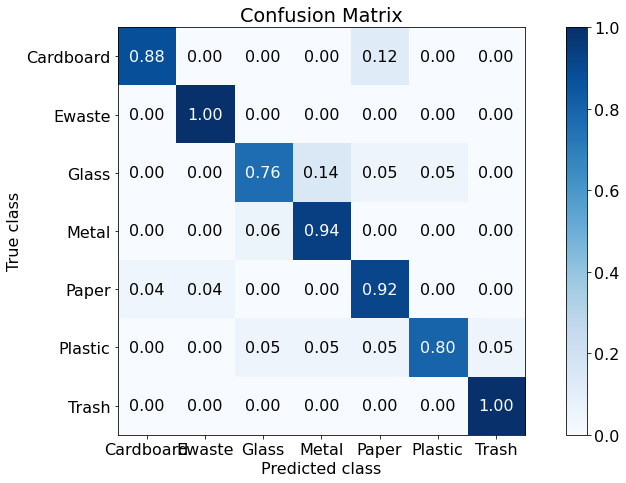

In [13]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(test_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    #else:
        #print('Confusion matrix, without normalization')

    #print(cm)
    fig, ax = plt.subplots(figsize=(12,7))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True class',
           xlabel='Predicted class')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=0, 
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax
plt.rc('font', family='SimHei', size=16)

classes = ['Cardboard', 'Ewaste', 'Glass', 'Metal', 'Paper', 'Plastic', 'Trash']
# Plot normalized confusion matrix
plot_confusion_matrix(test_true, test_pred, classes=classes, normalize=True, title='Confusion Matrix')
plt.show()

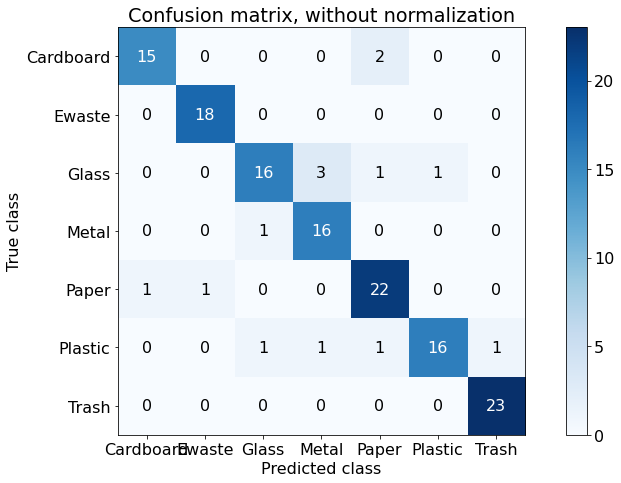

In [14]:
plot_confusion_matrix(test_true, test_pred, classes=classes, normalize=False)
plt.show()

In [15]:
print(classification_report(test_true, test_pred))

              precision    recall  f1-score   support

           0       0.94      0.88      0.91        17
           1       0.95      1.00      0.97        18
           2       0.89      0.76      0.82        21
           3       0.80      0.94      0.86        17
           4       0.85      0.92      0.88        24
           5       0.94      0.80      0.86        20
           6       0.96      1.00      0.98        23

    accuracy                           0.90       140
   macro avg       0.90      0.90      0.90       140
weighted avg       0.90      0.90      0.90       140



In [16]:
from sklearn.metrics import confusion_matrix

predictions_one_hot = model.predict(x_test)
cm = confusion_matrix(test_true, test_pred)
print(cm)

[[15  0  0  0  2  0  0]
 [ 0 18  0  0  0  0  0]
 [ 0  0 16  3  1  1  0]
 [ 0  0  1 16  0  0  0]
 [ 1  1  0  0 22  0  0]
 [ 0  0  1  1  1 16  1]
 [ 0  0  0  0  0  0 23]]


In [17]:
FP = cm.sum(axis=0) - np.diag(cm)  
FN = cm.sum(axis=1) - np.diag(cm)
TP = np.diag(cm)
TN = cm.sum() - (FP + FN + TP)

# Sensitivity, hit rate, recall, or true positive rate
TPR = TP/(TP+FN)
# Specificity or true negative rate
TNR = TN/(TN+FP) 
# Precision or positive predictive value
PPV = TP/(TP+FP)
# Negative predictive value
NPV = TN/(TN+FN)
# Fall out or false positive rate
FPR = FP/(FP+TN)
# False negative rate
FNR = FN/(TP+FN)
# False discovery rate
FDR = FP/(TP+FP)

Fscore = 2*(1/((1/PPV)+(1/TPR)))

# Overall accuracy
ACC = (TP+TN)/(TP+FP+FN+TN)

print(TPR)
print(TNR)
print(PPV)
print(NPV)
print(FNR)
print(FDR)
print(Fscore)
print(ACC)

[0.88235294 1.         0.76190476 0.94117647 0.91666667 0.8
 1.        ]
[0.99186992 0.99180328 0.98319328 0.96747967 0.96551724 0.99166667
 0.99145299]
[0.9375     0.94736842 0.88888889 0.8        0.84615385 0.94117647
 0.95833333]
[0.98387097 1.         0.95901639 0.99166667 0.98245614 0.96747967
 1.        ]
[0.11764706 0.         0.23809524 0.05882353 0.08333333 0.2
 0.        ]
[0.0625     0.05263158 0.11111111 0.2        0.15384615 0.05882353
 0.04166667]
[0.90909091 0.97297297 0.82051282 0.86486486 0.88       0.86486486
 0.9787234 ]
[0.97857143 0.99285714 0.95       0.96428571 0.95714286 0.96428571
 0.99285714]


Text(0, 0.5, 'Normalized percentage')

findfont: Font family ['SimHei'] not found. Falling back to DejaVu Sans.


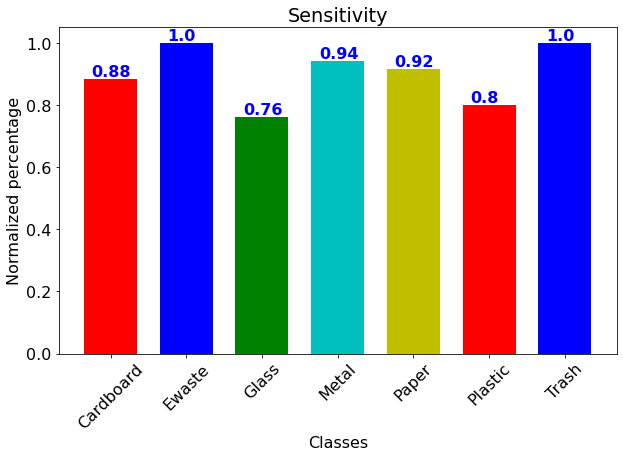

In [18]:
import numpy as np                                                               
import matplotlib.pyplot as plt

labels = classes
xs = np.arange(len(labels)) 
width = 0.7

f, ax = plt.subplots(figsize=(10,6))
plt.bar(xs, TPR, width, color = ['r','b','g','c','y','r','b'], align='center')

for i, v in enumerate(TPR):
    plt.text(i - 0.25, v + 0.01, str(round(v,2)), color='blue', fontweight='bold')

plt.xticks(xs, labels, rotation = 45) #Replace default x-ticks with xs, then replace xs with labels

plt.title('Sensitivity')
plt.xlabel('Classes')
plt.ylabel('Normalized percentage')

In [19]:
import plotly.graph_objects as go

colors = ['aliceblue','chocolate','fuchsia','lime','moccasin','tan','rebeccapurple']
fig = go.Figure(data=[
    go.Bar(name='Sensitivity', x=classes, y=TPR,marker_color = colors)
    
])
# Change the bar mode
fig.update_layout(title_text='Sensitivity')
fig.update_traces(texttemplate='%{y:0.3f}', textposition='outside',textfont_size=12)
fig.update_layout(font_size = 15)
fig.update_layout(barmode='group', xaxis_tickangle=-45)
fig.update_xaxes(title_text="Classes")
fig.update_yaxes(title_text="Normalized Values")
fig.show()

Text(0, 0.5, 'Normalized percentage')

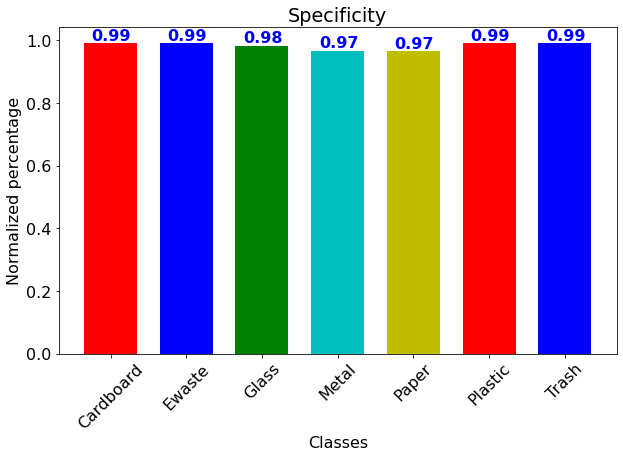

In [20]:
import numpy as np                                                               
import matplotlib.pyplot as plt

labels = classes
xs = np.arange(len(labels)) 
width = 0.7

f, ax = plt.subplots(figsize=(10,6))
plt.bar(xs, TNR, width, color = ['r','b','g','c','y','r','b'], align='center')

for i, v in enumerate(TNR):
    plt.text(i - 0.25, v + 0.01, str(round(v,2)), color='blue', fontweight='bold')

plt.xticks(xs, labels, rotation = 45) #Replace default x-ticks with xs, then replace xs with labels

plt.title('Specificity')
plt.xlabel('Classes')
plt.ylabel('Normalized percentage')

In [21]:
import plotly.graph_objects as go

colors = ['aliceblue','chocolate','fuchsia','lime','moccasin','tan','rebeccapurple']
fig = go.Figure(data=[
    go.Bar(name='Specificity', x=classes, y=TNR,marker_color = colors)
    
])
# Change the bar mode
fig.update_layout(title_text='Specificity')
fig.update_traces(texttemplate='%{y:0.3f}', textposition='outside',textfont_size=12)
fig.update_layout(font_size = 15)
fig.update_layout(barmode='group', xaxis_tickangle=-45)
fig.update_xaxes(title_text="Classes")
fig.update_yaxes(title_text="Normalized Values")
fig.show()

Text(0, 0.5, 'Normalized percentage')

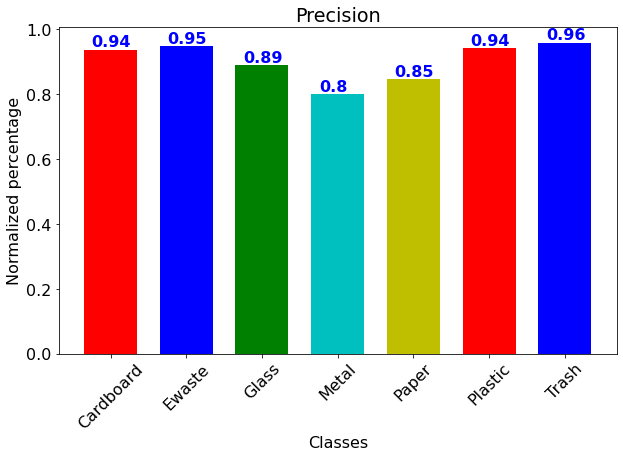

In [22]:
import numpy as np                                                               
import matplotlib.pyplot as plt

labels = classes
xs = np.arange(len(labels)) 
width = 0.7

f, ax = plt.subplots(figsize=(10,6))
plt.bar(xs, PPV, width, color = ['r','b','g','c','y','r','b'], align='center')

for i, v in enumerate(PPV):
    plt.text(i - 0.25, v + 0.01, str(round(v,2)), color='blue', fontweight='bold')

plt.xticks(xs, labels, rotation = 45) #Replace default x-ticks with xs, then replace xs with labels

plt.title('Precision')
plt.xlabel('Classes')
plt.ylabel('Normalized percentage')

In [23]:
import plotly.graph_objects as go

colors = ['aliceblue','chocolate','fuchsia','lime','moccasin','tan','rebeccapurple']
fig = go.Figure(data=[
    go.Bar(name='Precision', x=classes, y=PPV,marker_color = colors)
    
])
# Change the bar mode
fig.update_layout(title_text='Precision')
fig.update_traces(texttemplate='%{y:0.3f}', textposition='outside',textfont_size=12)
fig.update_layout(font_size = 15)
fig.update_layout(barmode='group', xaxis_tickangle=-45)
fig.update_xaxes(title_text="Classes")
fig.update_yaxes(title_text="Normalized Values")
fig.show()

Text(0, 0.5, 'Normalized percentage')

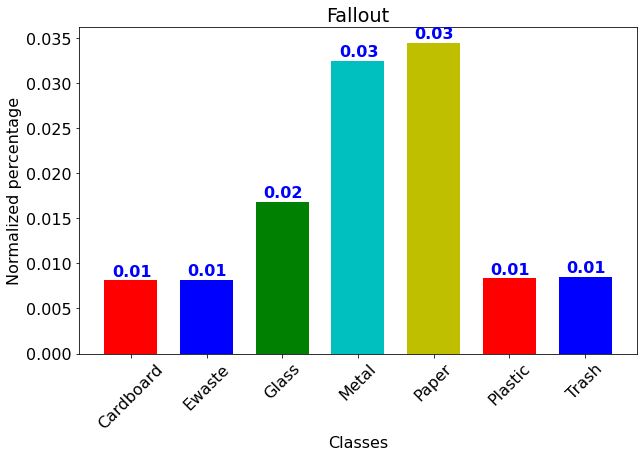

In [24]:
import numpy as np                                                               
import matplotlib.pyplot as plt

labels = classes
xs = np.arange(len(labels)) 
width = 0.7

f, ax = plt.subplots(figsize=(10,6))
plt.bar(xs, FPR, width, color = ['r','b','g','c','y','r','b'], align='center')

for i, v in enumerate(FPR):
    plt.text(i - 0.25, v + 0.0005, str(round(v,2)), color='blue', fontweight='bold')

plt.xticks(xs, labels, rotation = 45) #Replace default x-ticks with xs, then replace xs with labels

plt.title('Fallout')
plt.xlabel('Classes')
plt.ylabel('Normalized percentage')

In [25]:
import plotly.graph_objects as go

colors = ['aliceblue','chocolate','fuchsia','lime','moccasin','tan','rebeccapurple']
fig = go.Figure(data=[
    go.Bar(name='FallOut', x=classes, y=FPR,marker_color = colors)
    
])
# Change the bar mode
fig.update_layout(title_text='FallOut')
fig.update_traces(texttemplate='%{y:0.3f}', textposition='outside',textfont_size=12)
fig.update_layout(font_size = 15)
fig.update_layout(barmode='group', xaxis_tickangle=-45)
fig.update_xaxes(title_text="Classes")
fig.update_yaxes(title_text="Normalized Values")
fig.show()

Text(0, 0.5, 'Normalized percentage')

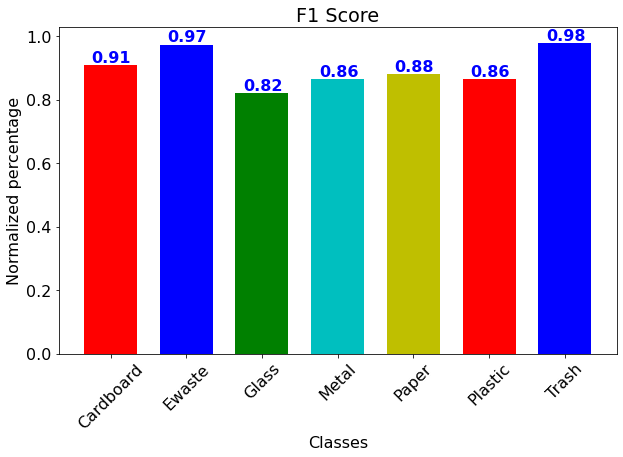

In [26]:
import numpy as np                                                               
import matplotlib.pyplot as plt

labels = classes
xs = np.arange(len(labels)) 
width = 0.7

f, ax = plt.subplots(figsize=(10,6))
plt.bar(xs, Fscore, width, color = ['r','b','g','c','y','r','b'], align='center')

for i, v in enumerate(Fscore):
    plt.text(i - 0.25, v + 0.01, str(round(v,2)), color='blue', fontweight='bold')

plt.xticks(xs, labels, rotation = 45) #Replace default x-ticks with xs, then replace xs with labels

plt.title('F1 Score')
plt.xlabel('Classes')
plt.ylabel('Normalized percentage')

In [27]:
import plotly.graph_objects as go

colors = ['aliceblue','chocolate','fuchsia','lime','moccasin','tan','rebeccapurple']
fig = go.Figure(data=[
    go.Bar(name='F1 Score', x=classes, y=Fscore,marker_color = colors)
    
])
# Change the bar mode
fig.update_layout(title_text='F1 Score')
fig.update_traces(texttemplate='%{y:0.3f}', textposition='outside',textfont_size=12)
fig.update_layout(font_size = 15)
fig.update_layout(barmode='group', xaxis_tickangle=-45)
fig.update_xaxes(title_text="Classes")
fig.update_yaxes(title_text="Normalized Values")
fig.show()

Text(0, 0.5, 'Normalized percentage')

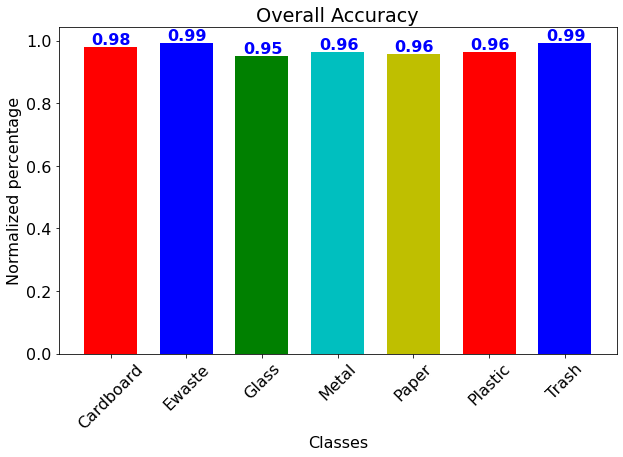

In [28]:
import numpy as np                                                               
import matplotlib.pyplot as plt

labels = classes
xs = np.arange(len(labels)) 
width = 0.7

f, ax = plt.subplots(figsize=(10,6))
plt.bar(xs, ACC, width, color = ['r','b','g','c','y','r','b'], align='center')

for i, v in enumerate(ACC):
    plt.text(i - 0.25, v + 0.01, str(round(v,2)), color='blue', fontweight='bold')

plt.xticks(xs, labels, rotation = 45) #Replace default x-ticks with xs, then replace xs with labels

plt.title('Overall Accuracy')
plt.xlabel('Classes')
plt.ylabel('Normalized percentage')

In [29]:
import plotly.graph_objects as go

colors = ['aliceblue','chocolate','fuchsia','lime','moccasin','tan','rebeccapurple']
fig = go.Figure(data=[
    go.Bar(name='Accuracy', x=classes, y=ACC,marker_color = colors),
    
])
# Change the bar mode
fig.update_layout(title_text='Accuracy')
fig.update_traces(texttemplate='%{y:0.3f}', textposition='outside',textfont_size=12)
fig.update_layout(font_size = 15)
fig.update_layout(barmode='group', xaxis_tickangle=-45)
fig.update_xaxes(title_text="Classes")
fig.update_yaxes(title_text="Normalized Values")
fig.show()

In [30]:
import plotly.graph_objects as go

fig = go.Figure(data=[
    go.Bar(name='Accuracy', x=classes, y=ACC),
    go.Bar(name='Precision', x=classes, y=PPV),
    go.Bar(name='Recall', x=classes, y=TPR)
])
# Change the bar mode
fig.update_traces(texttemplate='%{y:0.3f}', textposition='outside',textfont_size=10)
fig.update_layout(barmode='group')
fig.show()

In [31]:
import plotly.graph_objects as px 
import numpy 
  
x = classes
  
plot = px.Figure() 
  
plot.add_trace(px.Scatter( 
    name = 'Accuracy', 
    x = x, 
    y = ACC, 
    stackgroup='one',
    text = ACC,
    mode="lines+markers+text"
   )) 
  
plot.add_trace(px.Scatter( 
    name = 'F1 Score', 
    x = x, 
    y = Fscore, 
    stackgroup='two',
    text = Fscore,
    mode="lines+markers+text"
   ) 
) 

plot.add_trace(px.Scatter( 
    name = 'Precision', 
    x = x, 
    y = PPV, 
    stackgroup='three',
    text = PPV,
    mode="lines+markers+text"
   ) 
) 

plot.update_traces(texttemplate='%{text:0.3f}', textposition='top center',textfont_size=8)
plot.update_layout(font_size = 15)
plot.update_xaxes(title_text="Classes")
plot.update_yaxes(title_text="Normalized Values")  
plot.show()

In [32]:
def kappa_cal(matrix):
    n = np.sum(matrix)
    sum_po = 0
    sum_pe = 0
    for i in range(len(matrix[0])):
        sum_po += matrix[i][i]
        row = np.sum(matrix[i, :])
        col = np.sum(matrix[:, i])
        sum_pe += row * col
    po = sum_po / n
    pe = sum_pe / (n * n)
    # print(po, pe)
    return (po - pe) / (1 - pe)

kappa = kappa_cal(cm)
print(kappa)

0.8829990448901625


In [33]:
from sklearn.metrics import cohen_kappa_score
# Kappa coefficient is a model evaluation parameter based on the calculation of the confusion matrix (the closer to 1 the better)
kappa = cohen_kappa_score(np.array(test_true).reshape(-1,1), np.array(test_pred).reshape(-1,1))
print(kappa)

0.8829990448901623


In [34]:
from sklearn.metrics import hamming_loss
# Hamming distance (the closer to 0 the better)
ham_distance = hamming_loss(np.array(test_true).reshape(-1,1),np.array(test_pred).reshape(-1,1))
print(ham_distance)

0.1


In [35]:
from sklearn.metrics import jaccard_similarity_score
# Jackard's similarity coefficient (the closer to 1, the better)
# normalize is true by default. This is to calculate the average of the similarity coefficients of multiple categories. When normalize = false, the similarity coefficients of each category are calculated separately
jaccrd_score = jaccard_similarity_score(np.array(test_true).reshape(-1,1),np.array(test_pred).reshape(-1,1),normalize = True)
print(jaccrd_score)

0.9


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:664: FutureWarning:

jaccard_similarity_score has been deprecated and replaced with jaccard_score. It will be removed in version 0.23. This implementation has surprising behavior for binary and multiclass classification tasks.



In [36]:
from sklearn.metrics import matthews_corrcoef
matcoeff = matthews_corrcoef(test_true,test_pred)
print(matcoeff)

0.8838964823479473


In [37]:
# Print accurancy curve and loss curve
import csv
import matplotlib.pyplot as plt 
from matplotlib.pyplot import MultipleLocator

In [38]:
loss = []
val_loss = []
acc = []
val_acc = []

In [39]:
with open(r"/content/drive/MyDrive/MobileNet/result_show/mobilenet.csv",'r') as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:
        loss.append(float(row['loss']))
        val_loss.append(float(row['val_loss']))
        acc.append(float(row['accuracy']))
        val_acc.append(float(row['val_accuracy']))

In [40]:
epochs = range(1, len(loss) + 1)

findfont: Font family ['SimHei'] not found. Falling back to DejaVu Sans.


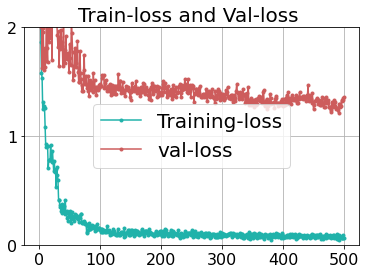

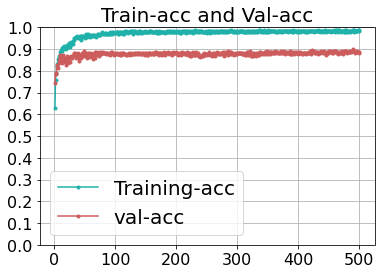

In [41]:
plt.ylim([0,2])
y_major_locator=MultipleLocator(1)
ax=plt.gca()
ax.yaxis.set_major_locator(y_major_locator)
plt.plot(epochs, loss, 'lightseagreen', label='Training-loss', marker='.', linestyle='-')
plt.plot(epochs, val_loss, 'indianred', label='val-loss', marker='.', linestyle='-')
plt.title('Train-loss and Val-loss ', fontsize=20)
plt.legend(fontsize=20)
plt.grid()


plt.figure()
plt.ylim([0,1])
y_major_locator=MultipleLocator(0.1)
ax=plt.gca()
ax.yaxis.set_major_locator(y_major_locator)
plt.plot(epochs, acc, 'lightseagreen', label='Training-acc', marker='.', linestyle='-')
plt.plot(epochs, val_acc, 'indianred', label='val-acc', marker='.', linestyle='-')
plt.title('Train-acc and Val-acc', fontsize=20)
plt.legend(fontsize=20)
plt.grid()
plt.show()

In [42]:
import plotly.graph_objects as px 
import numpy 
  
x = list(epochs)
  
plot = px.Figure() 
  
plot.add_trace(px.Scatter( 
    name = 'Training Accuracy', 
    x = x, 
    y = acc, 
   )) 
  
plot.add_trace(px.Scatter( 
    name = 'Validation Accuracy', 
    x = x, 
    y = val_acc, 
   ) 
) 


plot.update_traces(texttemplate='%{text:0.3f}', textposition='top center',textfont_size=8)
plot.update_layout(font_size = 15)
plot.update_xaxes(title_text="Epochs")
plot.update_yaxes(title_text="Normalized Values")  
plot.show()

In [43]:
import plotly.graph_objects as px 
import numpy 
  
x = list(epochs)
  
plot = px.Figure() 
  
plot.add_trace(px.Scatter( 
    name = 'Training Loss', 
    x = x, 
    y = loss, 
   )) 
  
plot.add_trace(px.Scatter( 
    name = 'Validation Loss', 
    x = x, 
    y = val_loss, 
   ) 
) 


plot.update_traces(texttemplate='%{text:0.3f}', textposition='top center',textfont_size=8)
plot.update_layout(font_size = 15)
plot.update_xaxes(title_text="Epochs")
plot.update_yaxes(title_text="Normalized Values")  
plot.show()

In [44]:
recall = []
precision = []
val_recall = []
val_precision = []

In [45]:
with open(r"/content/drive/MyDrive/MobileNet/result_show/mobilenet.csv",'r') as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:
        recall.append(float(row['recall']))
        val_recall.append(float(row['val_recall']))
        precision.append(float(row['precision']))
        val_precision.append(float(row['val_precision']))

In [46]:
epochs = range(1, len(loss) + 1)

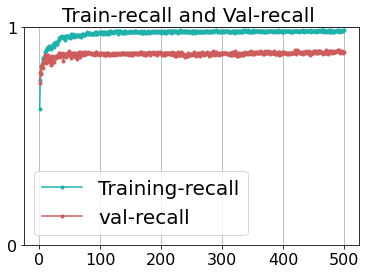

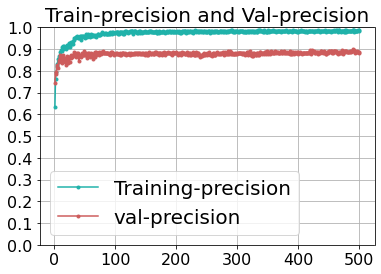

In [47]:
plt.ylim([0,1])
y_major_locator=MultipleLocator(1)
ax=plt.gca()
ax.yaxis.set_major_locator(y_major_locator)
plt.plot(epochs, recall, 'lightseagreen', label='Training-recall', marker='.', linestyle='-')
plt.plot(epochs, val_recall, 'indianred', label='val-recall', marker='.', linestyle='-')
plt.title('Train-recall and Val-recall ', fontsize=20)
plt.legend(fontsize=20)
plt.grid()


plt.figure()
plt.ylim([0,1])
y_major_locator=MultipleLocator(0.1)
ax=plt.gca()
ax.yaxis.set_major_locator(y_major_locator)
plt.plot(epochs, precision, 'lightseagreen', label='Training-precision', marker='.', linestyle='-')
plt.plot(epochs, val_precision, 'indianred', label='val-precision', marker='.', linestyle='-')
plt.title('Train-precision and Val-precision', fontsize=20)
plt.legend(fontsize=20)
plt.grid()
plt.show()

In [48]:
import plotly.graph_objects as px 
import numpy 
  
x = list(epochs)
  
plot = px.Figure() 
  
plot.add_trace(px.Scatter( 
    name = 'Training Recall', 
    x = x, 
    y = recall, 
   )) 
  
plot.add_trace(px.Scatter( 
    name = 'Validation Recall', 
    x = x, 
    y = val_recall, 
   ) 
) 


plot.update_traces(texttemplate='%{text:0.3f}', textposition='top center',textfont_size=8)
plot.update_layout(font_size = 15)
plot.update_xaxes(title_text="Epochs")
plot.update_yaxes(title_text="Normalized Values")  
plot.show()

In [49]:
import plotly.graph_objects as px 
import numpy 
  
x = list(epochs)
  
plot = px.Figure() 
  
plot.add_trace(px.Scatter( 
    name = 'Training Precision', 
    x = x, 
    y = precision, 
   )) 
  
plot.add_trace(px.Scatter( 
    name = 'Validation Precision', 
    x = x, 
    y = val_precision, 
   ) 
) 


plot.update_traces(texttemplate='%{text:0.3f}', textposition='top center',textfont_size=8)
plot.update_layout(font_size = 15)
plot.update_xaxes(title_text="Epochs")
plot.update_yaxes(title_text="Normalized Values")  
plot.show()

In [50]:
import plotly.graph_objects as px 
import numpy 
  
x = list(epochs)
  
plot = px.Figure() 
  
plot.add_trace(px.Scatter( 
    name = 'Accuracy', 
    x = x, 
    y = acc, 
    stackgroup='one',
   )) 
  
plot.add_trace(px.Scatter( 
    name = 'Recall', 
    x = x, 
    y = recall, 
    stackgroup='two',
   ) 
) 

plot.add_trace(px.Scatter( 
    name = 'Precision', 
    x = x, 
    y = precision, 
    stackgroup='three',
   ) 
) 

plot.update_traces(texttemplate='%{text:0.3f}', textposition='top center',textfont_size=8)
plot.update_layout(font_size = 15)
plot.update_xaxes(title_text="Epochs")
plot.update_yaxes(title_text="Normalized Values")  
plot.show()

In [51]:
import plotly.graph_objects as px 
import numpy 
  
x = list(epochs)
  
plot = px.Figure() 
  
plot.add_trace(px.Scatter( 
    name = 'Val_Accuracy', 
    x = x, 
    y = val_acc, 
    stackgroup='one',
   )) 
  
plot.add_trace(px.Scatter( 
    name = 'Val_Recall', 
    x = x, 
    y = val_recall, 
    stackgroup='two',
   ) 
) 

plot.add_trace(px.Scatter( 
    name = 'Val_Precision', 
    x = x, 
    y = val_precision, 
    stackgroup='three',
   ) 
) 

plot.update_traces(texttemplate='%{text:0.3f}', textposition='top center',textfont_size=8)
plot.update_layout(font_size = 15)
plot.update_xaxes(title_text="Epochs")
plot.update_yaxes(title_text="Normalized Values")  
plot.show()

In [52]:
import plotly.graph_objects as px 
import numpy 
  
x = list(epochs)
  
plot = px.Figure() 
  
plot.add_trace(px.Scatter( 
    name = 'Accuracy', 
    x = x, 
    y = acc, 
    stackgroup='one',
   )) 
  
plot.add_trace(px.Scatter( 
    name = 'Val_Accuracy', 
    x = x, 
    y = val_acc, 
    stackgroup='two',
   ) 
) 


plot.update_traces(texttemplate='%{text:0.3f}', textposition='top center',textfont_size=8)
plot.update_layout(font_size = 15)
plot.update_xaxes(title_text="Epochs")
plot.update_yaxes(title_text="Normalized Values")  
plot.show()

In [53]:
import plotly.graph_objects as px 
import numpy 
  
x = list(epochs)
  
plot = px.Figure() 
  
plot.add_trace(px.Scatter( 
    name = 'Recall', 
    x = x, 
    y = recall, 
    stackgroup='one',
   )) 
  
plot.add_trace(px.Scatter( 
    name = 'Val_Recall', 
    x = x, 
    y = val_recall, 
    stackgroup='two',
   ) 
) 


plot.update_traces(texttemplate='%{text:0.3f}', textposition='top center',textfont_size=8)
plot.update_layout(font_size = 15)
plot.update_xaxes(title_text="Epochs")
plot.update_yaxes(title_text="Normalized Values")  
plot.show()

In [54]:
import plotly.graph_objects as px 
import numpy 
  
x = list(epochs)
  
plot = px.Figure() 
  
plot.add_trace(px.Scatter( 
    name = 'Precision', 
    x = x, 
    y = precision, 
    stackgroup='one',
   )) 
  
plot.add_trace(px.Scatter( 
    name = 'Val_Precision', 
    x = x, 
    y = val_precision, 
    stackgroup='two',
   ) 
) 


plot.update_traces(texttemplate='%{text:0.3f}', textposition='top center',textfont_size=8)
plot.update_layout(font_size = 15)
plot.update_xaxes(title_text="Epochs")
plot.update_yaxes(title_text="Normalized Values")  
plot.show()

In [55]:
import plotly.graph_objects as px 
import numpy 
  
x = list(epochs)
  
plot = px.Figure() 
  
plot.add_trace(px.Scatter( 
    name = 'Accuracy', 
    x = x, 
    y = acc, 
   )) 
  
plot.add_trace(px.Scatter( 
    name = 'Val_Accuracy', 
    x = x, 
    y = val_acc, 
   ) 
) 


plot.update_traces(texttemplate='%{text:0.3f}', textposition='top center',textfont_size=8)
plot.update_layout(font_size = 15)
plot.update_xaxes(title_text="Epochs")
plot.update_yaxes(title_text="Normalized Values")  
plot.show()

In [56]:
import plotly.graph_objects as px 
import numpy 
  
x = list(epochs)
  
plot = px.Figure() 
  
plot.add_trace(px.Scatter( 
    name = 'Recall', 
    x = x, 
    y = recall, 
   )) 
  
plot.add_trace(px.Scatter( 
    name = 'Val_Recall', 
    x = x, 
    y = val_recall, 
   ) 
) 


plot.update_traces(texttemplate='%{text:0.3f}', textposition='top center',textfont_size=8)
plot.update_layout(font_size = 15)
plot.update_xaxes(title_text="Epochs")
plot.update_yaxes(title_text="Normalized Values")  
plot.show()

In [57]:
import plotly.graph_objects as px 
import numpy 
  
x = list(epochs)
  
plot = px.Figure() 
  
plot.add_trace(px.Scatter( 
    name = 'Precision', 
    x = x, 
    y = precision, 
   )) 
  
plot.add_trace(px.Scatter( 
    name = 'Val_Precision', 
    x = x, 
    y = val_precision, 
   ) 
) 


plot.update_traces(texttemplate='%{text:0.3f}', textposition='top center',textfont_size=8)
plot.update_layout(font_size = 15)
plot.update_xaxes(title_text="Epochs")
plot.update_yaxes(title_text="Normalized Values")  
plot.show()

In [58]:
import plotly.graph_objects as px 
import numpy 
  
x = list(epochs)
  
plot = px.Figure() 
  
plot.add_trace(px.Scatter( 
    name = 'Accuracy', 
    x = x, 
    y = acc, 
   )) 
  
plot.add_trace(px.Scatter( 
    name = 'Recall', 
    x = x, 
    y = recall, 
   ) 
) 

plot.add_trace(px.Scatter( 
    name = 'Precision', 
    x = x, 
    y = precision, 
   ) 
) 

plot.update_traces(texttemplate='%{text:0.3f}', textposition='top center',textfont_size=8)
plot.update_layout(font_size = 15)
plot.update_xaxes(title_text="Epochs")
plot.update_yaxes(title_text="Normalized Values")  
plot.show()

In [59]:
import plotly.graph_objects as px 
import numpy 
  
x = list(epochs)
  
plot = px.Figure() 
  
plot.add_trace(px.Scatter( 
    name = 'Val_Accuracy', 
    x = x, 
    y = val_acc, 
   )) 
  
plot.add_trace(px.Scatter( 
    name = 'Val_Recall', 
    x = x, 
    y = val_recall, 
   ) 
) 

plot.add_trace(px.Scatter( 
    name = 'Val_Precision', 
    x = x, 
    y = val_precision, 
   ) 
) 

plot.update_traces(texttemplate='%{text:0.3f}', textposition='top center',textfont_size=8)
plot.update_layout(font_size = 15)
plot.update_xaxes(title_text="Epochs")
plot.update_yaxes(title_text="Normalized Values")  
plot.show()